# DJIA Backtesting Result (Short selling is not allowed)

## Introduction
In this report, I backtest a simple strategy which predict the up and down trend by using top news in Reddit. The main classifier used is Bernuli classifier based on the discussion in Kaggle. In backtesting, I assume no short-selling is allowed in the market (the case when short selling is allowed will be discussed in another notebook). Different combinations of top news are backtested and the combination of top 3, top 10, top 25 news with 2-day shift according to AUC. The result varies when using Sharpe ratio. The best Sharpe ratio is achieved. Some possible improving methods will be discussed at the end and it turns out that using Neural Network as the classifier will achieve a little bit higher AUC (60%).

This whole Jupyter Notebook will be divided into 3 parts. Breif summary of each part is shown as follows:
* Part 1: Import required libraries, import DJIA price data and risk free information, defined several functions
* Part 2: Import modeling dataset, modeling and produce backtesting report
* Part 3: Discussions of potential ways for improving the result

## Key Assumptions
1. Short selling is not allowed.
2. All transaction cost, slippages are assumed to be 0, implied the market is frictionless.
3. Treat DJIA as something like a stock and the price is just the index level.
4. The initial investment is 100000

## Trading Strategy
* **Fill at T+0 adjusted close price**: Assume we can obtain that day's top 25 news before market close, we then generate a predicted moving direction of the market, let's say day i. If we do not have position in previous day (i-1) and if the prediction is 1, we invest all of our money in the DJIA, else (the prediction is 0), we just hold the money. If we have position in DJIA and if the prediction is 0, we clear our position at that day's adjusted close price, else (the prediction is 1), we just hold the shares. 
* **Fill at T+1 open price**: Assume we can obtain that day's top 25 news before the last minite of making a market open order, we then generate a predicted moving direction of the market. Let's say at day i, we get the signal. If we do not have position in day i and if the prediction is 1, we invest all of our money in the DJIA at the open price of day i+1, else (the prediction is 0), we just hold the money for day i+1. If we have position in DJIA at day i and if the prediction is 0, we clear our position at that day i+1's open price, else (the prediction is 1), we just hold the shares. 

## Performance Calculation
1. Assume trading days for a year is 252.
2. Use 13 week US Treasury bill rate as risk free rate (converted to daily rate).
3. Sharpe ratio is calculated on a yearly basis.
4. Maximum drawdown is calculated based on the whole period, not in the rolling window format. 

## Part 1: Pre-modeling Set up

### 1.1 Import required libraries

In [1]:
# Import required libraries
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import quandl
from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
# List to keep different methods scores to compare
ScoreSummaryByMethod=[]
FillAtClosePrice=[]
FillAtOpenPrice=[]

### 1.2 Import DJIA data and risk free rate

In [3]:
# Import DJIA data and risk free rate
DJIA=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/DJIA_table.csv')
DJIA['Date']=pd.to_datetime(DJIA['Date'])
# Import risk free rate (13 week US Treasury bill rate)
us_3m_tbill=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/USTREASURY-BILLRATES.csv')
us_3m_tbill['Date']=pd.to_datetime(us_3m_tbill['Date'])
rf_rate=us_3m_tbill[['Date','13 Wk Bank Discount Rate']]
rf_rate.columns=['Date','Risk free rate']
rf_rate['adjusted rf']=rf_rate['Risk free rate']/36000

### 1.3 Define several functions for further use
* text_process: text pre-processing
* ROCCurves: generate ROC curves
* heatmap: plot function
* plot_classification_report
* plot_confusion_matrix
* Evaluation: main function for evaluting the model, return AUC and other ket information
* **create_port**: create a portfolio for backtesting
* **backtest_close**: backtesting assume filling at T+0 adj close price
* **backtest_open**: backtesting assume filling at T+1 open price
* **performance**: generate performance report which indicates annualized return, annualized volatility, annualized Sharpe ratio, maximum drawdown

In [4]:
# Text pre-processing

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed

In [5]:
# ROC curve generation

def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [6]:
def heatmap(data, rotate_xticks=True):
  fig, ax = plt.subplots()
  heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
  ax.xaxis.tick_top()
  if rotate_xticks:
      plt.xticks(rotation=90)
  plt.yticks(rotation=0)

In [7]:
def plot_classification_report(classification_report):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

In [8]:
def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [9]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [10]:
# create a portfolio
def create_port(result):
    port=pd.merge(result,DJIA,how='left',on='Date')[['Date','Open','Adj Close','Label','predict']]
    port['shares hold']=0
    port['wealth']=0
    port['wealth'][0]=100000
    return port

In [11]:
# Backtest, assume fill at t+0 adjusted close price
# default slippage=0, transaction cost=0
def backtest_close(port, slippage=0, transaction_cost=0):
    #handle the starting day
    if port.loc[0,'predict']==1:
        port.loc[0,'shares hold']=port.loc[0,'wealth']/port.loc[0,'Adj Close']
    #handle the following days
    for i in range(1,port.index[-1]+1):
        if port.loc[i-1,'shares hold']==0: # no shares hold
            if port.loc[i,'predict']==1: # this is a buy signal
                #buy at adj_close(i)
                port.loc[i,'shares hold']=port.loc[i-1,'wealth']*(1-transaction_cost)/(port.loc[i,'Adj Close']*(1+slippage))
                #wealth at i
                port.loc[i,'wealth']=port.loc[i,'shares hold']*port.loc[i,'Adj Close']
            if port.loc[i,'predict']==0: # since we do not hold shares, do nothing since no short selling allowed
                port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                port.loc[i,'wealth']=port.loc[i-1,'wealth']
        if port.loc[i-1,'shares hold']!=0: # hold some shares
            if port.loc[i,'predict']==1: # hold since we have shares in hand
                #shares_hold(i)=shares_hold(i-1)
                port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                #calculate wealth at adj_close(i)
                port.loc[i,'wealth']=port.loc[i,'shares hold']*port.loc[i,'Adj Close']
            if port.loc[i,'predict']==0: # this is a sell signal (close position)
                #close the position
                port.loc[i,'shares hold']=0
                #wealth(i)=shares_hold(i-1)*adj_close(i)
                port.loc[i,'wealth']=port.loc[i-1,'shares hold']*port.loc[i,'Adj Close']*(1-slippage)
    port['return']=port['wealth'].pct_change()
    return pd.merge(portfolio,rf_rate,how='left',on='Date')[['Date','shares hold','wealth','return','adjusted rf']]

In [12]:
# Backtest, assume fill at t+1 open price
# default slippage=0, transaction cost=0, interest=0
def backtest_open(port,slippage=0, transaction_cost=0):
    for i in range(0,port.index[-1]-1):
        if port.loc[i,'shares hold']==0: #position at i is 0
            if port.loc[i,'predict']==1: #prediction at i is 1, this is a buy signal
                #wealth at i will not change, but the shares hold at i+1 will change, shares hold(i+1)=wealth(i)/Open(i+1)
                port.loc[i+1,'shares hold']=port.loc[i,'wealth']*(1-transaction_cost)/(port.loc[i+1,'Open']*(1+slippage))
                #wealth(i+1) will be shares hold(i+1)*Open(i+2), this is unrealized PnL, since you can not liquid
                port.loc[i+1,'wealth']=port.loc[i+1,'shares hold']*port.loc[i+2,'Open']
            if port.loc[i,'predict']==0: #prediction at i is 0, do nothing, just hold the money
                port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']
        if port.loc[i,'shares hold']!=0: #position at i is not 0
            if port.loc[i,'predict']==1: #prediction at i is 1, just hold the shares for i+1
                # shares at i+1 is the same as shares at i
                port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                #wealth at i+1 is the shares hold(i+1)*open(i+2), this is unrealized PnL, since you can not liquid
                #your position at the close price of i+1
                port.loc[i+1,'wealth']=port.loc[i+1,'shares hold']*port.loc[i+2,'Open']
            if port.loc[i,'predict']==0: #prediction at i is 0, this is a sell signal (close position)
                # shares at i+1 should be 0
                port.loc[i+1,'shares hold']=0
                # wealth at i+1 is shares hold(i)*Open(i+1)
                port.loc[i+1,'wealth']=port.loc[i,'shares hold']*port.loc[i+1,'Open']*(1-slippage)
        
    #handle the last day, just assume all position will be closed by that day's close price
    if port.loc[port.index[-1],'shares hold']==0:
        port.loc[port.index[-1],'wealth']=port.loc[port.index[-2],'wealth']
    else:
        port.loc[port.index[-1],'wealth']=port.loc[port.index[-1],'shares hold']*port.loc[port.index[-1],'Adj Close']
    
    port['return']=port['wealth'].pct_change()
    return pd.merge(portfolio,rf_rate,how='left',on='Date')[['Date','shares hold','wealth','return','adjusted rf']]

In [13]:
#report annualized return, volatility and Sharpe ratio
def performance(Method, Comment, fill_type, port,N=252):
    #default number of a year is N=252
    print("Classification method: ",Method)
    print("Paremeters choose: ", Comment)
    print("Order fill type: ", fill_type)
    #annualized mean of return
    annual_return=N*port['return'].mean()
    #annulized standard deviation
    annual_sd=np.sqrt(N)*port['return'].std()
    #annualized sharpe ratio
    #use 13-week US Treasury bill rate as risk free rate (benchmark)
    port['excess_return']=port['return']-port['adjusted rf']
    daily_sharpe=port['excess_return'].mean() / port['excess_return'].std()
    annual_sharpe=np.sqrt(N) * daily_sharpe
    
    hwm=[0.0]
    idx=port.index
    drawdown=pd.DataFrame(port['Date'])
    drawdown['dd']=0.0
    for i in range(1,len(idx)):
        current_hwm=max(hwm[i-1],port['wealth'][i])
        hwm.append(current_hwm)
        drawdown['dd'][i]=float((hwm[i]-port['wealth'][i]))/float(hwm[i])
    max_drawdown=drawdown['dd'].max()
    print("The annualized return is "+"{:.4%}".format(annual_return))
    print("The annualized volatility is "+"{:.4%}".format(annual_sd))
    print("The annualized Sharpe ratio is "+"{:.4}".format(annual_sharpe))
    print("The maximum drawdown during backtesting period is "+"{:.4%}".format(max_drawdown))
    drawdown.plot('Date', 'dd')
    if fill_type=='close':
        FillAtClosePrice.append([Method, Comment, annual_return, annual_sd, annual_sharpe,max_drawdown])
    if fill_type=='open':
        FillAtOpenPrice.append([Method, Comment, annual_return, annual_sd, annual_sharpe,max_drawdown])

## Part 2: Modeling and backtesting
The main task in this section is to model and backtest the strategy. The basic flow is:
1. Import modeling dataset
2. Combine predictions with DJIA dataset and backtesting the strategy by assuming filling at T+0 adjusted close price and T+1 open price respectively
3. Report the annulized return, annualized volatility, annualized Sharpe ratio and maximum drawdown

I will examine the following methods:
1. Baseline classifier: Naive Bayes classifier, no n-gram, no shift, combined all top news
2. Bernoulli Naive Bayes classifier, n-grams, alpha=1, no shift, combined all top news
3. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news
4. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 3-day shift, combined all top news
5. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 2-day shift, combined top3,top12 and top25 news

The comparison results are stores in the following tables:
1. df_ScoreSummaryByMethod: modeling scores for different methods
2. df_FillAtClosePrice: performance for different methods assuming filling at T+0 adjusted close price
3. df_FillAtOpenPrice: performance for different methods assuming filling at T+1 open price
The latter 2 tables are sorted by Sharpe ratio in descending order.


### Baseline classifier

In [14]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
# Import raw modeling dataset and split into train and test datasets
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
df.head()
# Split the dataset into train data and test data
# Train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
# Test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
nb_pipeline.fit(train['Combined'],train['Label'])
predictions = nb_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('MultinomialNB','no shift, no n-grams, combined Top news',test["Label"], predictions)

MultinomialNB
no shift, no n-grams, combined Top news
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       186
          1       0.51      1.00      0.67       192

avg / total       0.26      0.51      0.34       378

Confussion matrix:
 [[  0 186]
 [  0 192]]
ROC-AUC: 0.5


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification method:  MultinomialNB
Paremeters choose:  no shift, no n-grams, combined Top news
Order fill type:  close
The annualized return is 1.6299%
The annualized volatility is 15.4705%
The annualized Sharpe ratio is 0.1016
The maximum drawdown during backtesting period is 14.4831%


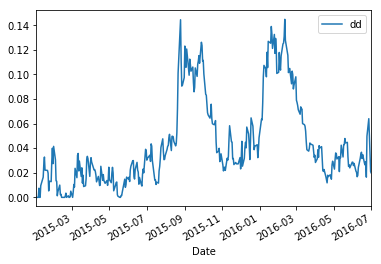

In [15]:
# Backtest at t+0 close price
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('MultinomialNB','no shift, no n-grams, combined Top news','close',result_close)

Classification method:  MultinomialNB
Paremeters choose:  no shift, no n-grams, combined Top news
Order fill type:  open
The annualized return is 1.4991%
The annualized volatility is 14.9374%
The annualized Sharpe ratio is 0.1061
The maximum drawdown during backtesting period is 14.4078%


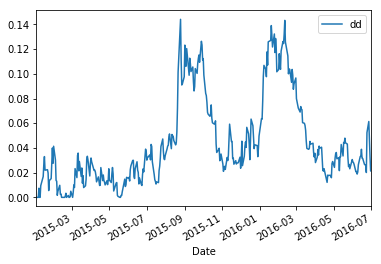

In [16]:
# Backtest at t+1 open price
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('MultinomialNB','no shift, no n-grams, combined Top news','open',result_open)

### Bernoulli Naive Bayes classifier, n-grams, alpha=1, no shift, combined all top news

In [17]:
#Creating a Data Pipeline for Bernoulli Naive Bayes classifier classifier and n-grams, default alpha=1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB(binarize=0.0)),  # train on TF-IDF vectors w/ Bernoulli Naive Bayes classifier
])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(binarize=0.0)
default alpha=1,no shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

          0       0.48      0.21      0.29       186
          1       0.51      0.78      0.61       192

avg / total       0.49      0.50      0.46       378

Confussion matrix:
 [[ 39 147]
 [ 42 150]]
ROC-AUC: 0.495463709677


Classification method:  BernoulliNB(binarize=0.0)
Paremeters choose:  default alpha=1,no shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is 2.0173%
The annualized volatility is 14.2772%
The annualized Sharpe ratio is 0.1225
The maximum drawdown during backtesting period is 14.7096%


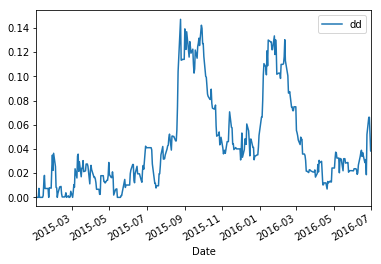

In [18]:
# Backtest at t+0 close price
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news','close',result_close)

Classification method:  BernoulliNB(binarize=0.0)
Paremeters choose:  default alpha=1,no shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is 1.8119%
The annualized volatility is 13.8517%
The annualized Sharpe ratio is 0.1159
The maximum drawdown during backtesting period is 14.7470%


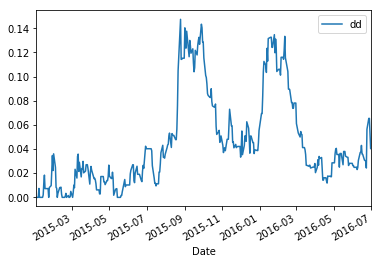

In [19]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news','open',result_open)

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news

In [20]:
#1 days shift
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]

In [21]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 1-day shift is smoothing alpha = 0 
# Update: alpha=0 can not generate the desired result, try alpha=0.1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.1, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.1,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.51      0.37      0.43       186
        1.0       0.51      0.65      0.57       191

avg / total       0.51      0.51      0.50       377

Confussion matrix:
 [[ 69 117]
 [ 67 124]]
ROC-AUC: 0.510091200811


Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is -0.6096%
The annualized volatility is 12.2400%
The annualized Sharpe ratio is -0.03981
The maximum drawdown during backtesting period is 11.4196%


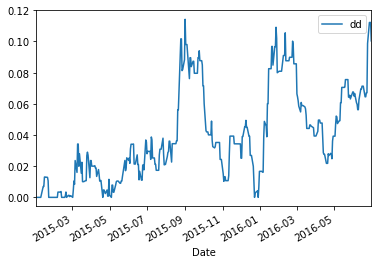

In [22]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','close',result_close)

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is -0.6152%
The annualized volatility is 11.7683%
The annualized Sharpe ratio is -0.03497
The maximum drawdown during backtesting period is 11.1642%


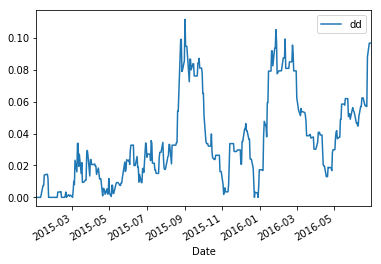

In [23]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','open',result_open)

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 3-day shift, combined all top news

In [24]:
#3 days shift
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-3)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]

In [25]:
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.56      0.40      0.47       184
        1.0       0.55      0.70      0.62       191

avg / total       0.56      0.55      0.54       375

Confussion matrix:
 [[ 74 110]
 [ 57 134]]
ROC-AUC: 0.551872296836


Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is 6.8561%
The annualized volatility is 12.6993%
The annualized Sharpe ratio is 0.5345
The maximum drawdown during backtesting period is 11.6385%


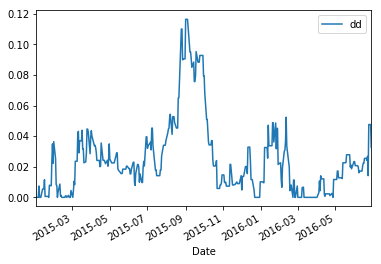

In [26]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is 4.9709%
The annualized volatility is 12.2046%
The annualized Sharpe ratio is 0.4012
The maximum drawdown during backtesting period is 11.7980%


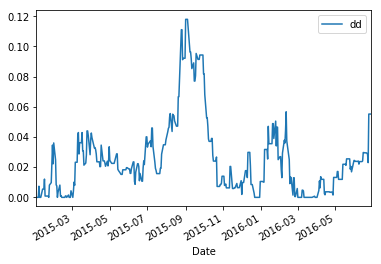

In [27]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news','open',result_open)

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 2-day shift, combined top3,top12 and top25 news

In [28]:
#Combine top 3, 12 ,25
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25']]
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.61      0.50      0.55       185
        1.0       0.58      0.69      0.63       191

avg / total       0.59      0.59      0.59       376

Confussion matrix:
 [[ 92  93]
 [ 60 131]]
ROC-AUC: 0.591580585821


Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  close
The annualized return is 0.6634%
The annualized volatility is 11.0030%
The annualized Sharpe ratio is 0.05485
The maximum drawdown during backtesting period is 16.2706%


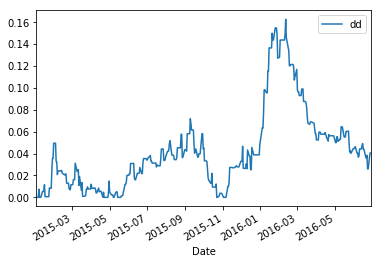

In [29]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  open
The annualized return is 1.8417%
The annualized volatility is 10.5734%
The annualized Sharpe ratio is 0.1827
The maximum drawdown during backtesting period is 15.3731%


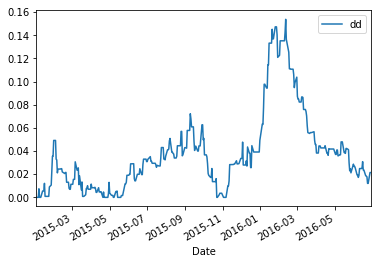

In [30]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','open',result_open)

### Summary table for different methods

In [31]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_FillAtClosePrice=DataFrame(FillAtClosePrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtClosePrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)
df_FillAtOpenPrice=DataFrame(FillAtOpenPrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtOpenPrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)

In [32]:
df_ScoreSummaryByMethod

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.591581,0.584821,0.593085,0.685864,0.631325
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.551872,0.549180,0.554667,0.701571,0.616092
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.510091,0.514523,0.511936,0.649215,0.574074
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.507937,0.507937,1.000000,0.673684
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.495464,0.505051,0.500000,0.781250,0.613497


In [33]:
df_FillAtClosePrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.068561,0.126993,0.534455,0.116385
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.020173,0.142772,0.122495,0.147096
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.016299,0.154705,0.101613,0.144831
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.006634,0.110030,0.054845,0.162706
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.006096,0.122400,-0.039810,0.114196


In [34]:
df_FillAtOpenPrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.049709,0.122046,0.401232,0.117980
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.018417,0.105734,0.182651,0.153731
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.018119,0.138517,0.115944,0.147470
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.014991,0.149374,0.106137,0.144078
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.006152,0.117683,-0.034966,0.111642


## Part 3: Improvement Methods
In this part, other than the data sources problem, I proposed the following three methods to improve the results:
* Method 1: Change the weights of different top news, or try different combinations of different news
* Method 2: Use other classification algorithms such as SVM, neural network. 
* Method 3: Use more advanced NLP method instead of 'bow' and 'tfidf'

Method 1 and method 2 are examined in the following section, which suggests that neural network can proved slightly better result with AUC=0.6. Changing weights of different top news seems has no effect on AUC.

### Method 1: Try different weights of top news
I just choose the best case above, and test when triple and quadruple the weight of top25 news, the AUC remains unchanged. 
Also, from the best solution in Kaggle, I found the AUC of combining top10 and top25 news is also pretty nice, so I try the combination of top3, top10, top12, top25 news, however, the result is not good.

In [36]:
#quadruple top 25 news, 2-day shift
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['top 25 copy1']=df['Top25']
df['top 25 copy2']=df['Top25']
df['top 25 copy3']=df['Top25']
df['Combined3_12_25*4']=df.iloc[:,[4,13,26,27,28,29]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25*4']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25*4']]
bnb_2ngram_pipeline.fit(train['Combined3_12_25*4'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25*4'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25*4',test["Label"], predictions)
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25*4
             precision    recall  f1-score   support

        0.0       0.61      0.50      0.55       185
        1.0       0.58      0.69      0.63       191

avg / total       0.59      0.59      0.59       376

Confussion matrix:
 [[ 92  93]
 [ 60 131]]
ROC-AUC: 0.591580585821


Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25*4
Order fill type:  close
The annualized return is 0.6634%
The annualized volatility is 11.0030%
The annualized Sharpe ratio is 0.05485
The maximum drawdown during backtesting period is 16.2706%


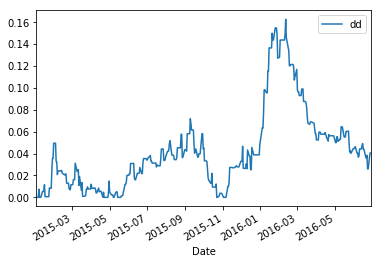

In [37]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25*4','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25*4
Order fill type:  open
The annualized return is 1.8417%
The annualized volatility is 10.5734%
The annualized Sharpe ratio is 0.1827
The maximum drawdown during backtesting period is 15.3731%


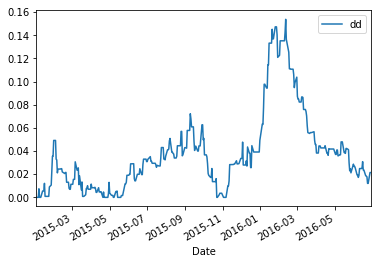

In [38]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25*4','open',result_open)

In [39]:
#combine top 3,10,12,25 news, 2-day shift
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_10_12_25']=df.iloc[:,[4,11,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_10_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_10_12_25']]
bnb_2ngram_pipeline.fit(train['Combined3_10_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_10_12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top 10,top12 and Top25',test["Label"], predictions)
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top 10,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.54      0.42      0.47       185
        1.0       0.54      0.65      0.59       191

avg / total       0.54      0.54      0.53       376

Confussion matrix:
 [[ 78 107]
 [ 66 125]]
ROC-AUC: 0.538035941701


Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3, top10, top12 and Top25
Order fill type:  close
The annualized return is -1.4300%
The annualized volatility is 11.2643%
The annualized Sharpe ratio is -0.1329
The maximum drawdown during backtesting period is 14.0201%


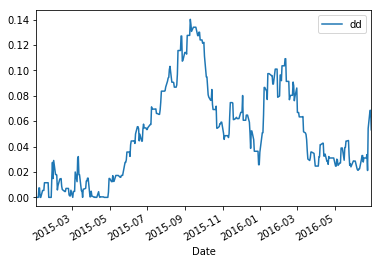

In [40]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3, top10, top12 and Top25','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3, top10, top12 and Top25
Order fill type:  open
The annualized return is -2.6096%
The annualized volatility is 10.8607%
The annualized Sharpe ratio is -0.2334
The maximum drawdown during backtesting period is 13.7820%


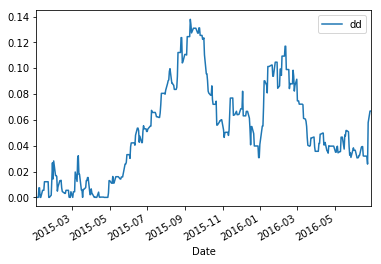

In [41]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3, top10, top12 and Top25','open',result_open)

#### Method 1 Conclusion
Therefore, we may conclude that by changing weight or the combination of top news may not have much effect on the fitness of classification. The NLP procedure may not be able to capture weights feature. Too many top news may provide too much noise during the modeling process.

### Method 2: Try other classification algorithms
I tried SVM and neural network respectively. SVM has no improvement for this modeling process at least in the case of combining all top news. Neural network can improve the AUC to 0.7 but the parameters are hard to obtain. The following is the result of applying neural network classification

In [42]:
#try neural network
df=pd.read_csv('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_DJIA.csv')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25']]
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100, 1), alpha=1e-4, random_state=1))])
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)
# best result for neural network is 0.597

MLPClassifier(alpha=1e-4,hidden_layer_size=100)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.61      0.51      0.56       185
        1.0       0.59      0.68      0.63       191

avg / total       0.60      0.60      0.60       376

Confussion matrix:
 [[ 95  90]
 [ 61 130]]
ROC-AUC: 0.597070892882


Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  close
The annualized return is 2.8778%
The annualized volatility is 10.9492%
The annualized Sharpe ratio is 0.258
The maximum drawdown during backtesting period is 12.1388%


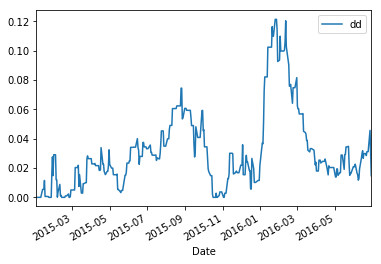

In [43]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','close',result_close)

Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  open
The annualized return is 3.3855%
The annualized volatility is 10.4838%
The annualized Sharpe ratio is 0.332
The maximum drawdown during backtesting period is 11.4296%


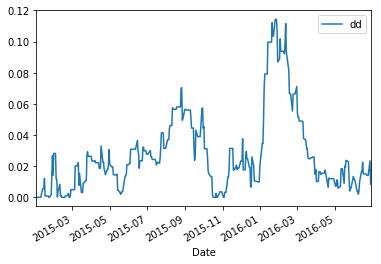

In [44]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','open',result_open)

#### Method 2 Conclusion:
Neural network seems to provide a better AUC but the Sharpe ratio is not the best. This is because I assume short selling is not allowed, indicates that the profit from short position can not be obtained. Also, we can see the improvement is not significant, which implies that we may consider deeper, which is the NLP procedure.

### Method 3: Use more advanced NLP methods
I haven't tested this one, but I got a good reference, which focusing on neural sentiment classification. I think the method used there for NLP can be referenced and I plan to try it in stage 2. The GitHub link is [here](https://github.com/thunlp/NSC).

## Summary Table Combining Improving Methods

In [45]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_FillAtClosePrice=DataFrame(FillAtClosePrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtClosePrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)
df_FillAtOpenPrice=DataFrame(FillAtOpenPrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtOpenPrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)

In [46]:
df_ScoreSummaryByMethod

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.597071,0.590909,0.598404,0.680628,0.632603
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.591581,0.584821,0.593085,0.685864,0.631325
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.591581,0.584821,0.593085,0.685864,0.631325
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.551872,0.549180,0.554667,0.701571,0.616092
6,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.538036,0.538793,0.539894,0.654450,0.591017
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.510091,0.514523,0.511936,0.649215,0.574074
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.507937,0.507937,1.000000,0.673684
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.495464,0.505051,0.500000,0.781250,0.613497


In [47]:
df_FillAtClosePrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.068561,0.126993,0.534455,0.116385
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",0.028778,0.109492,0.258001,0.121388
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.020173,0.142772,0.122495,0.147096
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.016299,0.154705,0.101613,0.144831
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.006634,0.110030,0.054845,0.162706
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.006634,0.110030,0.054845,0.162706
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.006096,0.122400,-0.039810,0.114196
6,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.014300,0.112643,-0.132856,0.140201


In [48]:
df_FillAtOpenPrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.049709,0.122046,0.401232,0.117980
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",0.033855,0.104838,0.331968,0.114296
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.018417,0.105734,0.182651,0.153731
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",0.018417,0.105734,0.182651,0.153731
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.018119,0.138517,0.115944,0.147470
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.014991,0.149374,0.106137,0.144078
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.006152,0.117683,-0.034966,0.111642
6,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.026096,0.108607,-0.233411,0.137820
